In [1]:
import numpy as np
import pandas as pd
import json
from IR.Searcher.Index_Searcher import Index_Searcher
from Scorer.MajorityVotingScorer import MajorityVotingScorer

In [2]:
# load the test_df from json
with open('../Data/Outputs/test_recommendations.json', 'r') as file:
    data = file.read()
    data = json.loads(data)

test_df = pd.DataFrame.from_dict(data)

In [3]:
# print the test_df
test_df.head()

,bug_id,ground_truth,repo,reformed_query,bug_title,bug_description,effective_queries,query_recommendations
0,289455,[org.eclipse.jdt.junit/src/org/eclipse/jdt/int...,eclipse.jdt.ui,[start create JUnit active active Bug active s...,[JUnit] JUnit view not active after test,I20090915-. JUnit view is not active after tes...,[start create JUnit active active Bug active s...,"[[JUnit, Java, fresh, Bug, view, Explorer], [J..."
1,165045,[ui/org.eclipse.pde.core/src/org/eclipse/pde/i...,eclipse.pde.ui,[icons actions importing created project build...,Import plugin with source leaves a warning ab...,After exporting a plug-in project with source ...,[icons actions importing created project build...,"[[export, file, references, Export, files, exp..."
2,49030,[java/org/apache/catalina/core/StandardService...,tomcat70,[listening situation uninitialized xml Server ...,Processing of Tomcat Connector configuration ...,If the Server part of the Tomcat configuratio...,[listening situation uninitialized xml Server ...,"[[problem, problem, wrong, wrong, incorrect, c..."
3,55582,[java/org/apache/jasper/compiler/TagFileProces...,tomcat70,[threads lines File TagFileProcessor wrapperUr...,Concurrent issue of TagFileProcessor,Created attachment [details] Unsynchronized g...,[threads lines File TagFileProcessor wrapperUr...,"[[issue, instance, Thread, Unsynchronized, Jsp..."
4,134483,[framework/bundles/org.eclipse.ecf/src/org/ecl...,ecf,[Application Container Standalone Factory Cont...,Standalone ClientApplication is breaks in lin...,The standalone org.eclipse.ecf.provider.app.Cl...,[Application Container Standalone Factory Cont...,"[[Eclipse, ExceptionInInitializerError, Client..."


## Now Evaluation

In [4]:
# load the index searcher
searcher = Index_Searcher()

In [5]:
all_ground_truths = []
all_search_results = []

### first collect all the search results for each query recommendation

In [12]:
# iterate over the test_df
for index, row in test_df.iterrows():
    # get query
    ground_truth = row['ground_truth']
    query_recommendations = row['query_recommendations']

    search_results_collection = []

    # iterate over query recommendations
    for recommendation in query_recommendations:
        query = ' '.join(recommendation)

        # get search results
        search_results = searcher.search(query=query, top_K_results=10)

        # append search results to search_results_collection
        search_results_collection.append(search_results)

    # Majority Voting Scorer
    # Scoring: after each round of searches for recommended queries, score the results
    majority_scorer = MajorityVotingScorer(List_Collection=search_results_collection)
    scored_list = majority_scorer.score_items(do_sort=True, only_keys_array=True)


    #trim the scored list to only contain the top 10 results
    scored_list = scored_list[:10]

    all_ground_truths.append(ground_truth)
    all_search_results.append(scored_list)

### Now evaluate the results

In [13]:
from Performance.Performance_Evaluator import Performance_Evaluator

performance_evaluator = Performance_Evaluator()

In [17]:
at_1 = performance_evaluator.evaluate(ground_truths=all_ground_truths, search_results=all_search_results, K=1)

In [18]:
at_5 = performance_evaluator.evaluate(ground_truths=all_ground_truths, search_results=all_search_results, K=5)

In [19]:
at_10 = performance_evaluator.evaluate(ground_truths=all_ground_truths, search_results=all_search_results, K=10)

In [22]:
t5_data = {
    'at_1': at_1,
    'at_5': at_5,
    'at_10': at_10
}

In [23]:
# print the results
print(t5_data)

{'at_1': {'map': 0.12954419895001987, 'mrr': 0.13062934809437954, 'recall@1': 0.045, 'hit@1': 0.07}, 'at_5': {'map': 0.12954419895001987, 'mrr': 0.13062934809437954, 'recall@5': 0.12576923076923077, 'hit@5': 0.21}, 'at_10': {'map': 0.12954419895001987, 'mrr': 0.13062934809437954, 'recall@10': 0.17326923076923076, 'hit@10': 0.28}}


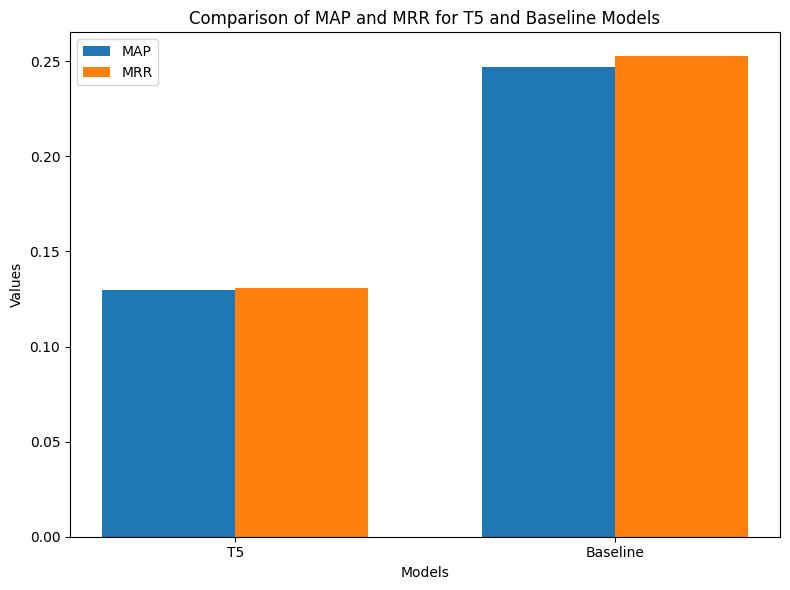

In [36]:
import matplotlib.pyplot as plt

# Data
models = ['T5', 'Baseline']
map_values = [0.12954419895001987, 0.24675]
mrr_values = [0.13062934809437954, 0.2526111111111111]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Width of the bars
bar_width = 0.35

# Bar positions
bar_positions1 = [1, 2]
bar_positions2 = [1 + bar_width, 2 + bar_width]

# Create bar plots for MAP and MRR
ax.bar(bar_positions1, map_values, bar_width, label='MAP')
ax.bar(bar_positions2, mrr_values, bar_width, label='MRR')

# Set axis labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_title('Comparison of MAP and MRR for T5 and Baseline Models')
ax.set_xticks([1 + bar_width / 2, 2 + bar_width / 2])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [37]:
# Programmatically remove 'mrr' and 'map' keys from the 't5' dictionary
for key in t5_data:
    t5_data[key].pop('mrr', None)
    t5_data[key].pop('map', None)

print(t5_data)

{'at_1': {'recall@1': 0.045, 'hit@1': 0.07}, 'at_5': {'recall@5': 0.12576923076923077, 'hit@5': 0.21}, 'at_10': {'recall@10': 0.17326923076923076, 'hit@10': 0.28}}


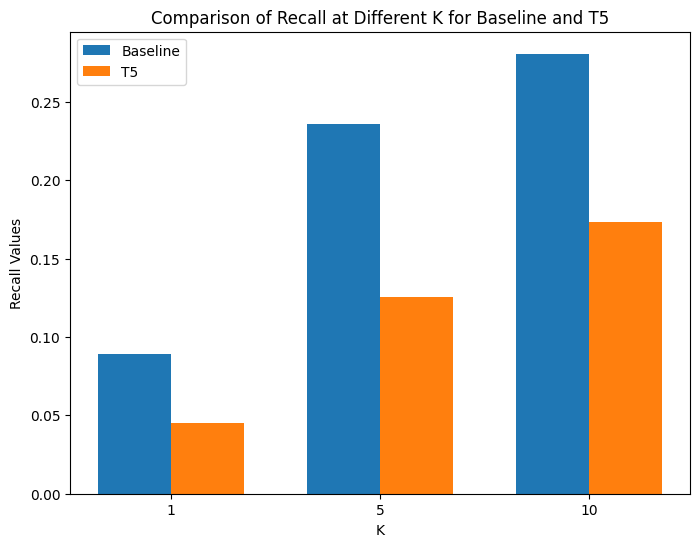

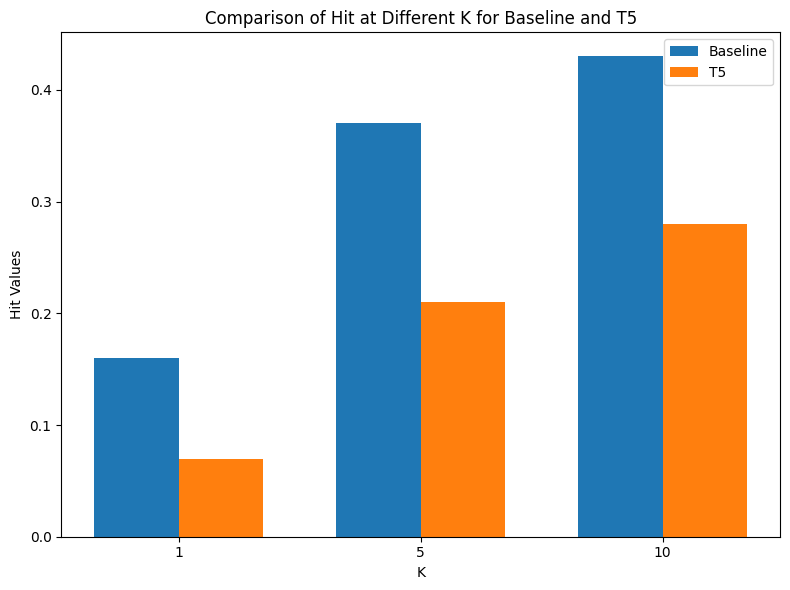

In [40]:
import matplotlib.pyplot as plt

# Data for Baseline
baseline_recall = [0.0891025641025641, 0.23576923076923076, 0.28076923076923077]
baseline_hit = [0.16, 0.37, 0.43]

# Data for T5
t5_recall = [0.045, 0.12576923076923077, 0.17326923076923076]
t5_hit = [0.07, 0.21, 0.28]

# Create a figure and axis for Recall comparison
fig, ax1 = plt.subplots(figsize=(8, 6))

# Width of the bars
bar_width = 0.35

# Bar positions
bar_positions1 = [1, 2, 3]
bar_positions2 = [1 + bar_width, 2 + bar_width, 3 + bar_width]

# Create bar plots for Recall comparison
ax1.bar(bar_positions1, baseline_recall, bar_width, label='Baseline')
ax1.bar(bar_positions2, t5_recall, bar_width, label='T5')

# Set axis labels and title for Recall comparison
ax1.set_xlabel('K')
ax1.set_ylabel('Recall Values')
ax1.set_title('Comparison of Recall at Different K for Baseline and T5')
ax1.set_xticks([1 + bar_width / 2, 2 + bar_width / 2, 3 + bar_width / 2])
ax1.set_xticklabels(['1', '5', '10'])
ax1.legend()

# Create a figure and axis for Hit comparison
fig, ax2 = plt.subplots(figsize=(8, 6))

# Create bar plots for Hit comparison
ax2.bar(bar_positions1, baseline_hit, bar_width, label='Baseline')
ax2.bar(bar_positions2, t5_hit, bar_width, label='T5')

# Set axis labels and title for Hit comparison
ax2.set_xlabel('K')
ax2.set_ylabel('Hit Values')
ax2.set_title('Comparison of Hit at Different K for Baseline and T5')
ax2.set_xticks([1 + bar_width / 2, 2 + bar_width / 2, 3 + bar_width / 2])
ax2.set_xticklabels(['1', '5', '10'])
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()
